In [15]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False 

from shapely.geometry import Polygon
from pyproj import Transformer
from ast import literal_eval

# 1. 데이터 불러오기 및 전처리
- (`area_results`, `wifi_count_by_area`, `foot_traffic_data_loc`)

In [ ]:
FOOT_TRAFFIC_DATA_PATH = './data/Foot-Trafic/api_data/Foot-Traffic-DataSet/'
PLACE116_COOR = './data/all_coord_df.csv'
WIFI_COOR = './data/Public-WiFi/PublicWiFi.csv'

## 1-1. 116개의 명소별 면적

In [38]:
import geopandas as gpd

In [39]:
# 116개의 명소 경계좌표
coor_116place = pd.read_csv(PLACE116_COOR, index_col=0)

In [40]:
# 좌표 변환기 (EPSG:4326 -> EPSG:5179)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:5179", always_xy=True)

In [41]:
# 면적 계산 함수 (M^2 단위)
def calculate_area_m2(row):
    polygon_coords = []

    # 다각형 좌표 추출 및 변환
    for col in coor_116place.columns[4:]:
        if not pd.isna(row[col]):  # NaN 값이 아닌 경우만 처리
            coord = literal_eval(row[col])
            polygon_coords.append((coord[0], coord[1]))  # (경도, 위도)

    # 좌표 변환 및 면적 계산
    if polygon_coords:
        # 좌표 변환 (EPSG:4326 -> EPSG:5179)
        transformed_coords = [
            transformer.transform(lon, lat) for lon, lat in polygon_coords
        ]

        # 다각형 생성 및 면적 계산
        polygon = Polygon(transformed_coords)
        return polygon.area / 1_000  # 면적을 M^2 단위로 변환
    return 0

In [42]:
# 면적 계산 (벡터화)
coor_116place["AREA_M2"] = coor_116place.apply(calculate_area_m2, axis=1)

# 결과 저장
area_gdf = coor_116place[["AREA_NM", "AREA_M2"]]

In [43]:
# 다각형 생성
polygons = []
names = []
for _, row in coor_116place.iterrows():
    polygon_coords = []
    for col in coor_116place.columns[3:]:  # 좌표 데이터가 3열부터 시작
        if not pd.isna(row[col]):  # NaN 값이 아닌 경우만 처리
            coord_value = row[col]
            if isinstance(coord_value, str) and coord_value.startswith("(") and coord_value.endswith(")"):
                try:
                    coord = literal_eval(coord_value)  # 문자열 -> (경도, 위도) 튜플 변환
                    polygon_coords.append((coord[0], coord[1]))  # (경도, 위도)
                except (ValueError, SyntaxError):
                    continue

    if polygon_coords:  # 다각형 좌표가 존재하면
        polygon = Polygon(polygon_coords)
        polygons.append(polygon)
        names.append(row['AREA_NM'])

In [44]:
# GeoDataFrame 생성
area_results = gpd.GeoDataFrame(
    {'AREA_NM': names, 'geometry': polygons},
    crs="EPSG:4326"
)

In [45]:
len(area_results['AREA_NM'].unique())

115

In [46]:
area_results

,AREA_NM,geometry
0,강남 MICE 관광특구,"POLYGON ((127.06028 37.5139, 127.0604 37.51385..."
1,동대문 관광특구,"POLYGON ((127.01759 37.5695, 127.01772 37.5693..."
2,명동 관광특구,"POLYGON ((126.97601 37.56067, 126.97602 37.560..."
3,이태원 관광특구,"POLYGON ((126.99125 37.5303, 126.99121 37.5302..."
4,잠실 관광특구,"POLYGON ((127.09307 37.51051, 127.09272 37.511..."
...,...,...
110,잠원한강공원,"POLYGON ((127.02121 37.53022, 127.02357 37.532..."
111,청계산,"POLYGON ((127.04946 37.45425, 127.06166 37.439..."
112,청와대,"POLYGON ((126.97924 37.58373, 126.97925 37.583..."
113,북창동 먹자골목,"POLYGON ((126.97601 37.56067, 126.97602 37.560..."


In [47]:
area_results['AREA_M2'] = area_gdf['AREA_M2']

## 1-2. 지역별 와이파이 개수

In [48]:
from shapely.geometry import Point, Polygon
from ast import literal_eval

In [49]:
wifi_data = pd.read_csv(WIFI_COOR, index_col=0)
wifi_data.head(3)

,시도,시군구,상세주소,ap명,위도,경도
번호,,,,,,
1,강원도,강릉시,옥계면 금진리 464-1번지,(재)한국여성수련원,37.629313,129.046503
2,강원도,강릉시,옥계면 금진리 464-1번지,(재)한국여성수련원,37.629313,129.046503
3,강원도,강릉시,옥계면 금진리 464-1번지,(재)한국여성수련원,37.629313,129.046503


In [50]:
wifi_data = wifi_data[wifi_data['시도']=='서울특별시']

In [51]:
# 2. 명소 영역을 40미터 확장 (buffer 사용, 단위는 CRS에 따라 결정됨)
# 와이파이 사용 가능 범위인 40m 적용하여 와이파이 개수 계산
buffered_area_results = area_results.copy()
buffered_area_results = buffered_area_results.to_crs(epsg=5179)

# 명소 영역을 40미터 확장
buffered_area_results['geometry'] = buffered_area_results.geometry.buffer(40)

# 다시 EPSG:4326으로 변환
buffered_area_results = buffered_area_results.to_crs(epsg=4326)

In [52]:
public_wifi_gdf = gpd.GeoDataFrame(
    wifi_data,
    geometry=gpd.points_from_xy(wifi_data['경도'], wifi_data['위도']),
    crs="EPSG:4326"
)

In [53]:
joined_gdf = gpd.sjoin(public_wifi_gdf, buffered_area_results, how='right', predicate='intersects')

In [54]:
wifi_count_by_area = joined_gdf.groupby('AREA_NM').size().reset_index(name='WiFi_Count')

## 1-3. 유동인구수

In [55]:
foottraffic_file_names = os.listdir(FOOT_TRAFFIC_DATA_PATH)

In [56]:
dataframes = []
for dataset_name in foottraffic_file_names :
    file_path = FOOT_TRAFFIC_DATA_PATH+dataset_name
    df = pd.read_csv(file_path, encoding='euc-kr')
    dataframes.append(df)

FileNotFoundError: [Errno 2] No such file or directory: './data/Foot-Trafic/api_data/Foot-Traffic-DataSet4·19 카페거리.csv'

In [ ]:
dataframes = []
for dataset_name in foottraffic_file_names :
    file_path = FOOT_TRAFFIC_DATA_PATH+dataset_name
    df = pd.read_csv(file_path, encoding='euc-kr')
    dataframes.append(df)

In [ ]:
foot_traffic_data = pd.concat(dataframes, ignore_index=True)

In [ ]:
foot_traffic_data.rename(columns={'핫스팟 장소명':'AREA_NM'}, inplace=True)

In [ ]:
foot_traffic_data['실시간 인구현황'].isnull().count()

np.int64(172650)

In [ ]:
foot_traffic_data.drop(columns=['실시간 인구현황'], inplace=True)

In [ ]:
foot_traffic_data.columns = foot_traffic_data.columns.str.replace(' ', '')

In [ ]:
foot_traffic_data['AREA_NM'].unique()

array(['4·19 카페거리', 'DDP(동대문디자인플라자)', 'DMC(디지털미디어시티)', '가락시장', '가로수길',
       '가산디지털단지역', '강남 MICE 관광특구', '강남역', '강서한강공원', '건대입구역', '경복궁', '고덕역',
       '고속터미널역', '고척돔', '광나루한강공원', '광장(전통)시장', '광화문·덕수궁', '광화문광장', '교대역',
       '구로디지털단지역', '구로역', '국립중앙박물관·용산가족공원', '군자역', '김포공항', '낙산공원·이화마을',
       '난지한강공원', '남구로역', '남대문시장', '남산공원', '노들섬', '노량진', '대림역', '덕수궁길·정동길',
       '동대문 관광특구', '동대문역', '뚝섬역', '뚝섬한강공원', '망원한강공원', '명동 관광특구', '미아사거리역',
       '반포한강공원', '발산역', '방배역 먹자골목', '보신각', '북서울꿈의숲', '북창동 먹자골목', '북촌한옥마을',
       '북한산우이역', '불광천', '사당역', '삼각지역', '서리풀공원·몽마르뜨공원', '서울 암사동 유적',
       '서울광장', '서울대공원', '서울대입구역', '서울숲공원', '서울식물원·마곡나루역', '서울역', '서촌',
       '선릉역', '성수카페거리', '성신여대입구역', '수유리 먹자골목', '수유역', '신논현역·논현역', '신도림역',
       '신림역', '신촌·이대역', '쌍문동 맛집거리', '아차산', '압구정로데오거리', '양재역', '양화한강공원',
       '어린이대공원', '여의도', '여의도한강공원', '역삼역', '연남동', '연신내역', '영등포 타임스퀘어',
       '오목교역·목동운동장', '왕십리역', '외대앞', '용리단길', '용산역', '월드컵공원', '응봉산',
       '이촌한강공원', '이태원 관광특구', '이태원 앤틱가구거리', '이태원역', '익선동', '인사

In [ ]:
foot_traffic_data.loc[foot_traffic_data['AREA_NM'] == '인사동', 'AREA_NM'] = '인사동·익선동'
foot_traffic_data.loc[foot_traffic_data['AREA_NM'] == '익선동', 'AREA_NM'] = '인사동·익선동'

In [ ]:
foot_traffic_data_loc = pd.merge(foot_traffic_data, 
                                 wifi_count_by_area,
                                 on='AREA_NM',
                                 how='left')

In [ ]:
foot_traffic_data_loc['실시간인구데이터업데이트시간'] = pd.to_datetime(
    foot_traffic_data_loc['실시간인구데이터업데이트시간'], errors='coerce'
)

In [ ]:
foot_traffic_data_loc.dropna(axis=0, inplace=True)

In [ ]:
foot_traffic_data_loc['요일'] = foot_traffic_data_loc['실시간인구데이터업데이트시간'].dt.day_name(locale='ko_KR')
foot_traffic_data_loc['시간대'] = foot_traffic_data_loc['실시간인구데이터업데이트시간'].dt.hour

# 2. 데이터 분석

## 2-1. 데이터 병합

In [ ]:
# area_results와 foot_traffic_loc 병합
foot_traffic_loc_with_area = pd.merge(
    foot_traffic_data_loc,        
    area_results,             
    on="AREA_NM",       
    how="left"               
)

In [ ]:
foot_traffic_loc_with_area.head(2)

,AREA_NM,장소혼잡도지표,실시간인구지표최소값,실시간인구지표최대값,상주인구비율,비상주인구비율,실시간인구데이터업데이트시간,WiFi_Count,요일,시간대,geometry,AREA_M2
0,4·19 카페거리,여유,1000,1500,31.6,68.4,2024-11-13 10:55:00,2,수요일,10,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139
1,4·19 카페거리,여유,1000,1500,30.9,69.1,2024-11-13 11:00:00,2,수요일,11,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139


In [ ]:
foot_traffic_loc_with_area['유동인구_밀집도'] = (
    foot_traffic_loc_with_area['실시간인구지표최대값'] / foot_traffic_loc_with_area['AREA_M2']
)

In [ ]:
foot_traffic_loc_with_area['와이파이_밀집도'] = (
    foot_traffic_loc_with_area['WiFi_Count'] / foot_traffic_loc_with_area['AREA_M2']
)

In [ ]:
foot_traffic_loc_with_area.head(2)

,AREA_NM,장소혼잡도지표,실시간인구지표최소값,실시간인구지표최대값,상주인구비율,비상주인구비율,실시간인구데이터업데이트시간,WiFi_Count,요일,시간대,geometry,AREA_M2,유동인구_밀집도,와이파이_밀집도
0,4·19 카페거리,여유,1000,1500,31.6,68.4,2024-11-13 10:55:00,2,수요일,10,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139,16.243586,0.021658
1,4·19 카페거리,여유,1000,1500,30.9,69.1,2024-11-13 11:00:00,2,수요일,11,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139,16.243586,0.021658


## 2-2. 클러스터링

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
# 주요 변수 선택
features = [
    "실시간인구지표최대값",
    "장소혼잡도지표",
    "비상주인구비율",
    "WiFi_Count",
    "요일",
    "시간대",
    "유동인구_밀집도",
    "와이파이_밀집도"
]


In [7]:
# 클러스터링 변수 추출
X = foot_traffic_loc_with_area[features]

NameError: name 'foot_traffic_loc_with_area' is not defined

In [ ]:
X['장소혼잡도지표'].unique()

array(['여유', '보통', '약간 붐빔', '붐빔'], dtype=object)

In [ ]:
congestion_day = {
    "여유":0,
    "보통":1,
    "약간 붐빔":2,
    "붐빔":3
}

foot_traffic_loc_with_area["장소혼잡도지표_숫자"] = foot_traffic_loc_with_area["장소혼잡도지표"].map(congestion_day)
X["장소혼잡도지표_숫자"] = foot_traffic_loc_with_area["장소혼잡도지표"].map(congestion_day)

C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\3433639179.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["장소혼잡도지표_숫자"] = foot_traffic_loc_with_area["장소혼잡도지표"].map(congestion_day)


In [ ]:
X['요일'].unique()

array(['수요일', '목요일', '금요일', '토요일', '일요일', '월요일', '화요일'], dtype=object)

In [8]:
# 요일 수치화 (0=월요일, 6=일요일)
day_mapping = {
    "월요일": 0,
    "화요일": 1,
    "수요일": 2,
    "목요일": 3,
    "금요일": 4,
    "토요일": 5,
    "일요일": 6
}
X["요일"] = X["요일"].map(day_mapping)
foot_traffic_loc_with_area['요일_숫자'] = foot_traffic_loc_with_area['요일'].map(day_mapping)

NameError: name 'X' is not defined

In [9]:
X['요일'].unique()

NameError: name 'X' is not defined

In [49]:
# 주기적 변환 (사인/코사인)
# 요일은 시간 데이터와 마찬가지로 주기성을 가지며, 순환 구조를 고려
foot_traffic_loc_with_area["요일_사인"] = np.sin(2 * np.pi * X["요일"] / 7)
X["요일_사인"] = np.sin(2 * np.pi * X["요일"] / 7)
X['요일_사인'].unique()

C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\731321687.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["요일_사인"] = np.sin(2 * np.pi * X["요일"] / 7)


array([ 0.97492791,  0.43388374, -0.43388374, -0.97492791, -0.78183148,
        0.        ,  0.78183148])

In [50]:
# 주요 변수 선택
features = [
    "실시간인구지표최대값",
    "장소혼잡도지표_숫자",
    "비상주인구비율",
    "WiFi_Count",
    "요일_사인",
    "시간대",
    "유동인구_밀집도",
    "와이파이_밀집도"
]

In [51]:
from sklearn.preprocessing import StandardScaler

# 데이터 정규화
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X[features])

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172650 entries, 0 to 172649
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   실시간인구지표최대값  172650 non-null  int64  
 1   장소혼잡도지표     172650 non-null  object 
 2   비상주인구비율     172650 non-null  float64
 3   WiFi_Count  172650 non-null  int64  
 4   요일          172650 non-null  int64  
 5   시간대         172650 non-null  int32  
 6   유동인구_밀집도    172650 non-null  float64
 7   와이파이_밀집도    172650 non-null  float64
 8   장소혼잡도지표_숫자  172650 non-null  int64  
 9   요일_사인       172650 non-null  float64
dtypes: float64(4), int32(1), int64(4), object(1)
memory usage: 12.5+ MB


In [53]:
X_scaled = X[features]

In [54]:
from sklearn.cluster import KMeans

In [55]:
from sklearn.metrics import pairwise_distances
from tqdm import tqdm

In [56]:
def pairwise_distances_batch(X, labels, batch_size=32):
    """
    Silhouette 점수를 배치 단위로 계산하며 진행 상태를 출력
    """
    unique_labels = np.unique(labels)
    n_samples = X.shape[0]
    a = np.zeros(n_samples)  # 동일 클러스터 평균 거리
    b = np.full(n_samples, np.inf)  # 다른 클러스터 평균 거리

    # tqdm 설정
    total_progress = tqdm(total=n_samples, desc="Silhouette 계산 진행", position=0)

    # 배치 처리
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        X_batch = X[start:end]
        distances = pairwise_distances(X_batch, X)  # 배치 단위 거리 계산

        # 각 배치의 데이터에 대해 거리 계산
        for i, row in enumerate(distances):
            global_idx = start + i  # 전체 데이터에서 현재 인덱스
            same_cluster = labels == labels[global_idx]  # 동일 클러스터
            other_clusters = labels != labels[global_idx]  # 다른 클러스터

            # 동일 클러스터 평균 거리 계산
            if np.sum(same_cluster) > 1:
                a[global_idx] = np.mean(row[same_cluster])

            # 다른 클러스터 평균 거리 계산
            for label in unique_labels:
                if label != labels[global_idx]:
                    b[global_idx] = min(b[global_idx], np.mean(row[labels == label]))

            # 진행 상태 업데이트
            total_progress.update(1)

    total_progress.close()

    # Silhouette 점수 계산
    s = (b - a) / np.maximum(a, b)
    s[np.isnan(s)] = 0  # NaN 값 처리
    return np.mean(s)


# 엘보우 기법: 군집 개수에 따른 Inertia 값 계산
def elbow_method(X_scaled, k_range):
    inertia = []
    for k in tqdm(k_range, desc="엘보우 기법 진행"):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    # 엘보우 기법 결과 시각화
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertia, 'bo-')
    plt.xlabel('군집 개수')
    plt.ylabel('Inertia (클러스터 내 오차 제곱합)')
    plt.title('엘보우 기법에 의한 군집 개수 평가')
    plt.show()

    return inertia

# 실루엣 점수 계산
def silhouette_analysis(X_scaled, candidate_k, batch_size=32):
    silhouette_scores = []
    for k in tqdm(candidate_k, desc="실루엣 점수 계산 진행"):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = pairwise_distances_batch(X_scaled, labels, batch_size=batch_size)
        silhouette_scores.append(score)

    # 실루엣 점수 결과 시각화
    plt.figure(figsize=(8, 5))
    plt.plot(candidate_k, silhouette_scores, 'bo-')
    plt.xlabel('군집 개수')
    plt.ylabel('실루엣 점수')
    plt.title('실루엣 점수에 의한 군집 개수 평가')
    plt.show()

    # 최적 군집 개수 선택
    optimal_k = candidate_k[silhouette_scores.index(max(silhouette_scores))]
    return optimal_k, max(silhouette_scores)

# 실행
def find_optimal_clusters(X_scaled, batch_size=32):
    # 1. 엘보우 기법 실행
    k_range = range(2, 11)  # 테스트할 군집 개수 범위
    inertia = elbow_method(X_scaled, k_range)

    # 엘보우 기법 결과를 기반으로 후보 군집 개수 선택
    # 예: 수동으로 3~5를 선택했다고 가정
    candidate_k = [4, 5, 6]

    # 2. 실루엣 점수 분석
    optimal_k, best_score = silhouette_analysis(X_scaled, candidate_k, batch_size=batch_size)

    print(f"최적 군집 개수: {optimal_k}, 실루엣 점수: {best_score}")
    return optimal_k, best_score

엘보우 기법 진행: 100%|██████████| 9/9 [00:00<00:00,  9.67it/s]


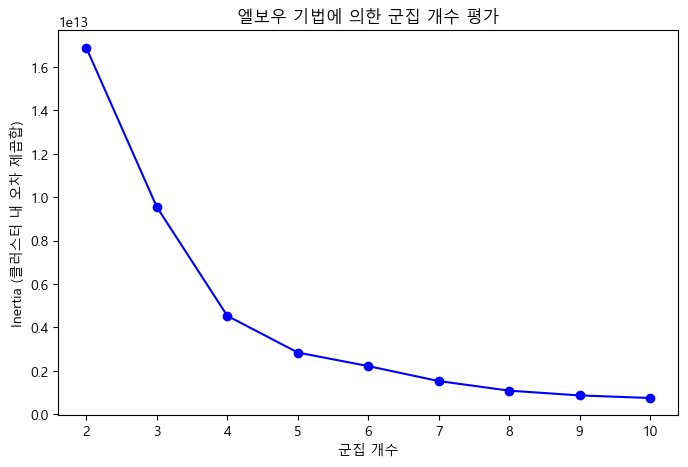

실루엣 점수 계산 진행: 100%|██████████| 3/3 [13:34<00:00, 271.48s/it]


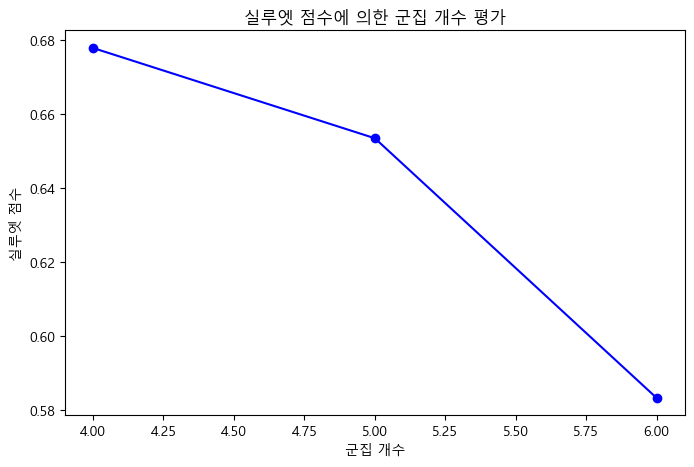

최적 군집 개수: 4, 실루엣 점수: 0.6779652776479556


In [57]:
optimal_k, best_score = find_optimal_clusters(X_scaled, batch_size=100)

In [58]:
kmeans = KMeans(n_clusters=4, random_state=42)
foot_traffic_loc_with_area['CLUSTERING'] = kmeans.fit_predict(X_scaled)

## 2-3. 클러스터링 분석

In [59]:
foot_traffic_loc_with_area.head(3)

,AREA_NM,장소혼잡도지표,실시간인구지표최소값,실시간인구지표최대값,상주인구비율,비상주인구비율,실시간인구데이터업데이트시간,WiFi_Count,요일,시간대,geometry,AREA_M2,유동인구_밀집도,와이파이_밀집도,장소혼잡도지표_숫자,요일_숫자,요일_사인,CLUSTERING
0,4·19 카페거리,여유,1000,1500,31.6,68.4,2024-11-13 10:55:00,2,수요일,10,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139,16.243586,0.021658,0,2,0.974928,2
1,4·19 카페거리,여유,1000,1500,30.9,69.1,2024-11-13 11:00:00,2,수요일,11,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139,16.243586,0.021658,0,2,0.974928,2
2,4·19 카페거리,여유,1000,1500,30.6,69.4,2024-11-13 11:10:00,2,수요일,11,"POLYGON ((127.01047 37.64733, 127.01066 37.645...",92.344139,16.243586,0.021658,0,2,0.974928,2


### 2-3-1. 지도

In [60]:
foot_traffic_loc_with_area['CLUSTERING'].value_counts()

CLUSTERING
2    111929
0     49852
1     10408
3       461
Name: count, dtype: int64

In [78]:
max_traffic_by_hour_and_location = (
    foot_traffic_loc_with_area.groupby(['시간대', 'AREA_NM', 'WiFi_Count', 'geometry', 'CLUSTERING'])[['유동인구_밀집도', '와이파이_밀집도']]
    .mean()
    .reset_index()
)

In [80]:
# 클러스터별 색상 매핑
color_mapping = {
    0: "red",
    1: "blue",
    2: "yellow",
    3: "green"
}

In [81]:
import folium
import folium
from shapely.wkt import loads

import folium
from shapely.wkt import loads

# 지도 초기화 (서울 중심 좌표 사용)
seoul_map = folium.Map(location=[37.5665, 126.9780], zoom_start=11)

# 클러스터별 색상 매핑
color_mapping = {
    0: "red",
    1: "blue",
    2: "yellow",
    3: "green"
}

# 와이파이 데이터 추가
wifi_layer = folium.FeatureGroup(name="WiFi Locations", show=True)
for _, wifi_row in wifi_data.iterrows():
    # 와이파이 위치를 40m 반경의 원으로 추가
    folium.Circle(
        location=[wifi_row["위도"], wifi_row["경도"]],
        radius=40,  # 반경 40m
        color="purple",
        fill=True,
        fill_color="purple",
        fill_opacity=0.4,
        tooltip=wifi_row["ap명"],
    ).add_to(wifi_layer)

# 와이파이 레이어 지도에 추가
wifi_layer.add_to(seoul_map)

# 시간대별 Layer 추가
time_slots = sorted(max_traffic_by_hour_and_location["시간대"].unique())
for time_slot in time_slots:
    # 시간대별 데이터 필터링
    time_data = max_traffic_by_hour_and_location[
        max_traffic_by_hour_and_location["시간대"] == time_slot
    ]
    
    # FeatureGroup 생성 (각 시간대별로 Layer 분리)
    feature_group = folium.FeatureGroup(name=f"{time_slot}시", show=(time_slot == 10))  # 기본적으로 10시 활성화

    for _, row in time_data.iterrows():
        # 다각형 좌표 추출
        polygon = row["geometry"]
        if isinstance(polygon, str):  # 문자열인 경우 WKT를 로드하여 Polygon 생성
            polygon = loads(polygon)

        # 다각형 좌표 변환 (shapely geometry -> list of lat/lon pairs)
        polygon_coords = [[point[1], point[0]] for point in polygon.exterior.coords]

        # 팝업 정보 생성
        popup_html = f"""
        <div style="width: 200px;">
            <strong>장소명: {row['AREA_NM']}</strong><br>
            클러스터: {row['CLUSTERING']}<br>
            WiFi 개수: {row['WiFi_Count']}<br>
            WiFi 밀집도: {row['와이파이_밀집도']}<br>
            유동인구 밀집도: {row['유동인구_밀집도']:.2f}
        </div>
        """
        popup = folium.Popup(popup_html, max_width=250)

        # 다각형 추가
        folium.Polygon(
            locations=polygon_coords,  # 다각형 좌표
            color=color_mapping[row["CLUSTERING"]],  # 클러스터별 색상
            fill=True,  # 채우기 여부
            fill_color=color_mapping[row["CLUSTERING"]],  # 채우기 색상
            fill_opacity=0.4,  # 투명도
            popup=popup,  # 팝업 추가
            tooltip=row["AREA_NM"],  # 마우스 오버 시 표시되는 이름
        ).add_to(feature_group)

    # 시간대별 레이어 추가
    feature_group.add_to(seoul_map)

# LayerControl 추가 (시간대별 레이어 및 와이파이 레이어 선택 가능)
folium.LayerControl(collapsed=False).add_to(seoul_map)

# 지도 저장
output_file = "time_based_max_traffic_clusters_with_wifi.html"
seoul_map.save(output_file)
print(f"지도가 '{output_file}'로 저장되었습니다.")

지도가 'time_based_max_traffic_clusters_with_wifi.html'로 저장되었습니다.


클러스터링된 각각의 군집이 어떠한 의미를 가지고 있는지 분석해야함

### 2-3-2. 군집 의미 파악

In [65]:
features = [
    "실시간인구지표최대값",
    "장소혼잡도지표_숫자",
    "비상주인구비율",
    "WiFi_Count",
    "요일_숫자",
    "시간대",
    "유동인구_밀집도",
    "와이파이_밀집도"
]

In [66]:
foot_traffic_loc_with_area['CLUSTERING'].value_counts()

CLUSTERING
2    111929
0     49852
1     10408
3       461
Name: count, dtype: int64

C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\344090924.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(


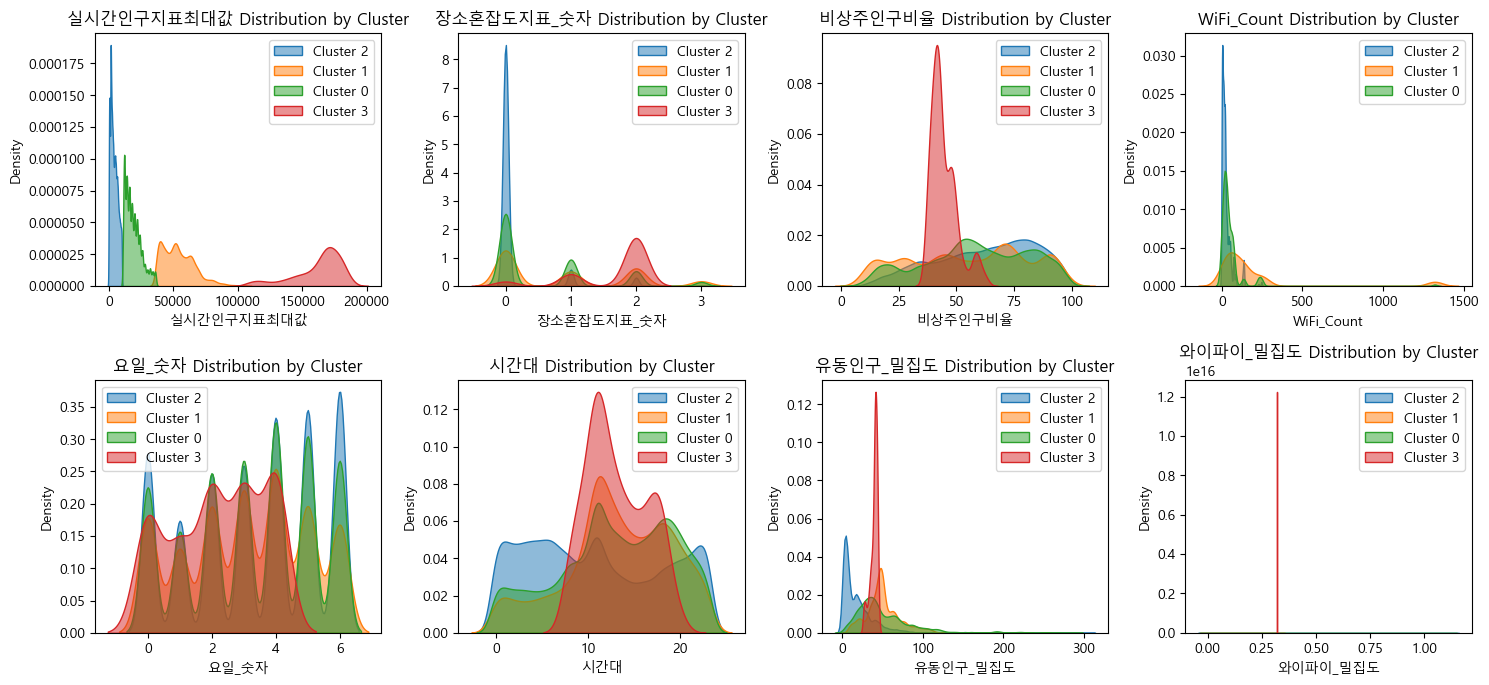

In [68]:
# KDE 플롯 시각화
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 4, i + 1)
    for cluster in foot_traffic_loc_with_area["CLUSTERING"].unique():
        sns.kdeplot(
            data=foot_traffic_loc_with_area[foot_traffic_loc_with_area["CLUSTERING"] == cluster],
            x=feature,
            label=f"Cluster {cluster}",
            fill=True,
            alpha=0.5
        )
    plt.title(f"{feature} Distribution by Cluster")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()


Cluster 2 - 중요 변수 분석
      Feature  Importance
4    유동인구_밀집도    0.343998
3  WiFi_Count    0.254114
5    와이파이_밀집도    0.193805
0  장소혼잡도지표_숫자    0.080919
1      상주인구비율    0.045917
2     비상주인구비율    0.039413
7         시간대    0.036145
6       요일_사인    0.005690


C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\1344571461.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")


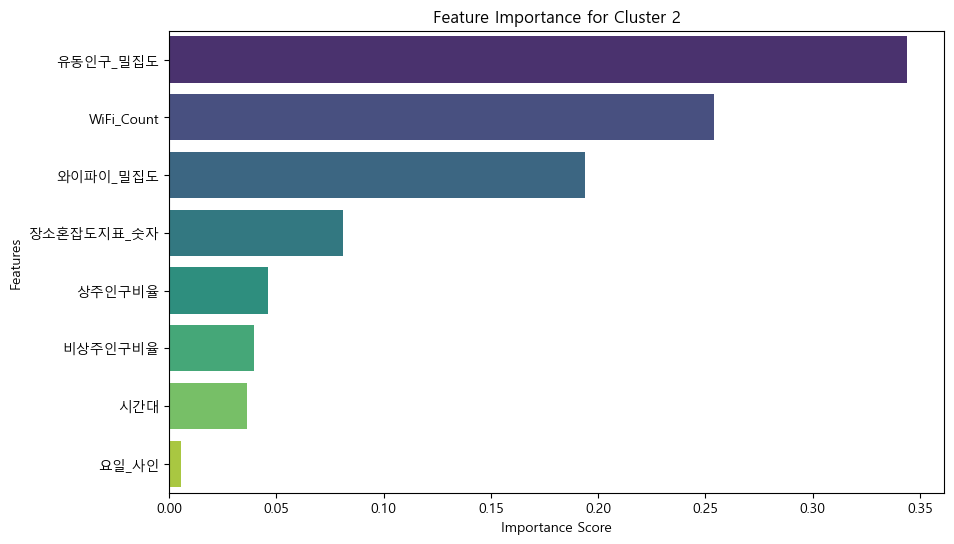


Permutation Importance:
      Feature  Importance
4    유동인구_밀집도    0.320515
3  WiFi_Count    0.242129
5    와이파이_밀집도    0.156913
0  장소혼잡도지표_숫자    0.016174
7         시간대    0.001416
1      상주인구비율    0.000762
2     비상주인구비율    0.000220
6       요일_사인    0.000023


C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\1344571461.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_importance_df, x="Importance", y="Feature", palette="viridis")


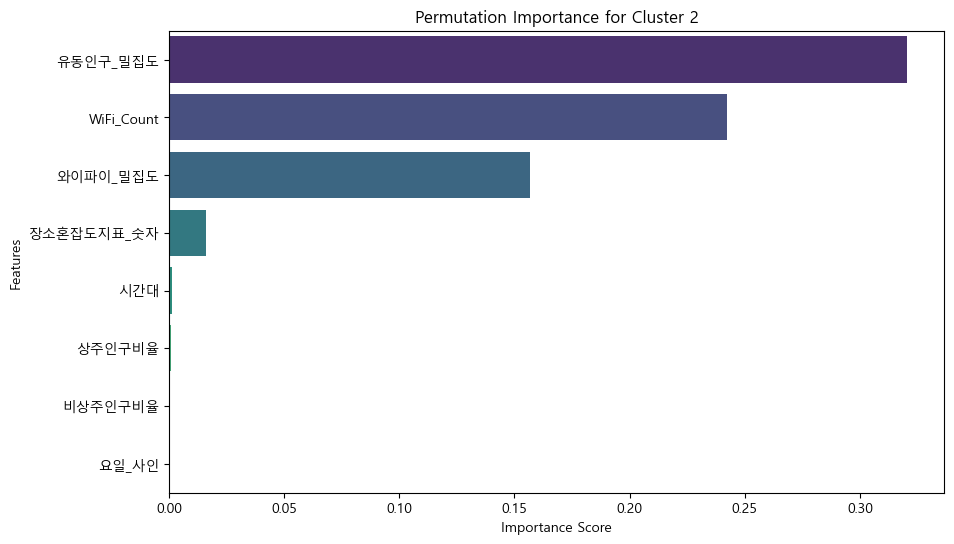

Cluster 1 - 중요 변수 분석
      Feature  Importance
3  WiFi_Count    0.381214
5    와이파이_밀집도    0.217891
4    유동인구_밀집도    0.199143
2     비상주인구비율    0.058534
1      상주인구비율    0.055543
0  장소혼잡도지표_숫자    0.041855
7         시간대    0.036579
6       요일_사인    0.009241


C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\1344571461.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")


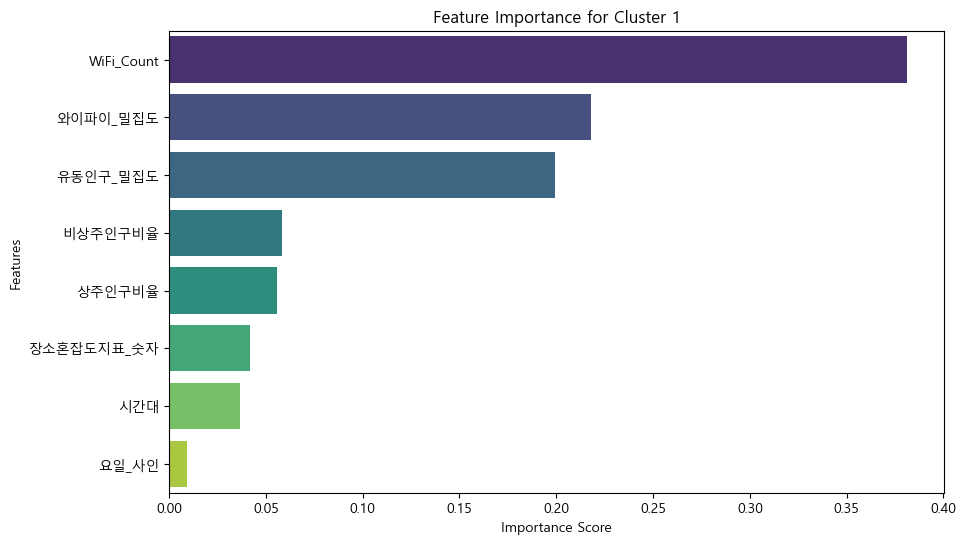


Permutation Importance:
      Feature  Importance
3  WiFi_Count    0.083078
4    유동인구_밀집도    0.046323
5    와이파이_밀집도    0.035753
0  장소혼잡도지표_숫자    0.006112
7         시간대    0.000401
6       요일_사인    0.000318
2     비상주인구비율    0.000084
1      상주인구비율    0.000035


C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\1344571461.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_importance_df, x="Importance", y="Feature", palette="viridis")


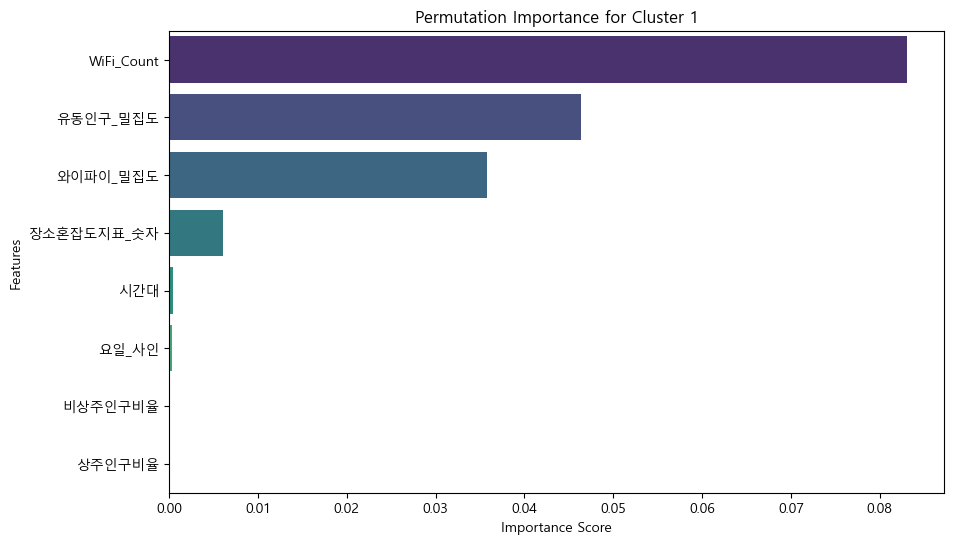

Cluster 0 - 중요 변수 분석
      Feature  Importance
4    유동인구_밀집도    0.321640
3  WiFi_Count    0.245304
5    와이파이_밀집도    0.221864
1      상주인구비율    0.055755
0  장소혼잡도지표_숫자    0.053669
2     비상주인구비율    0.049274
7         시간대    0.042909
6       요일_사인    0.009584


C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\1344571461.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")


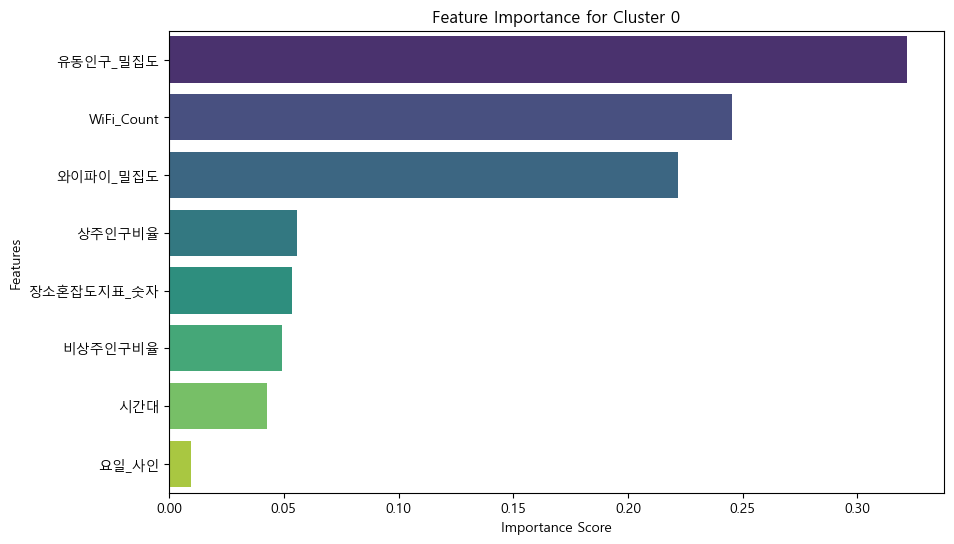


Permutation Importance:
      Feature  Importance
4    유동인구_밀집도    0.295610
3  WiFi_Count    0.211936
5    와이파이_밀집도    0.155416
0  장소혼잡도지표_숫자    0.016132
2     비상주인구비율    0.003779
7         시간대    0.003136
1      상주인구비율    0.002944
6       요일_사인    0.000125


C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\1344571461.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_importance_df, x="Importance", y="Feature", palette="viridis")


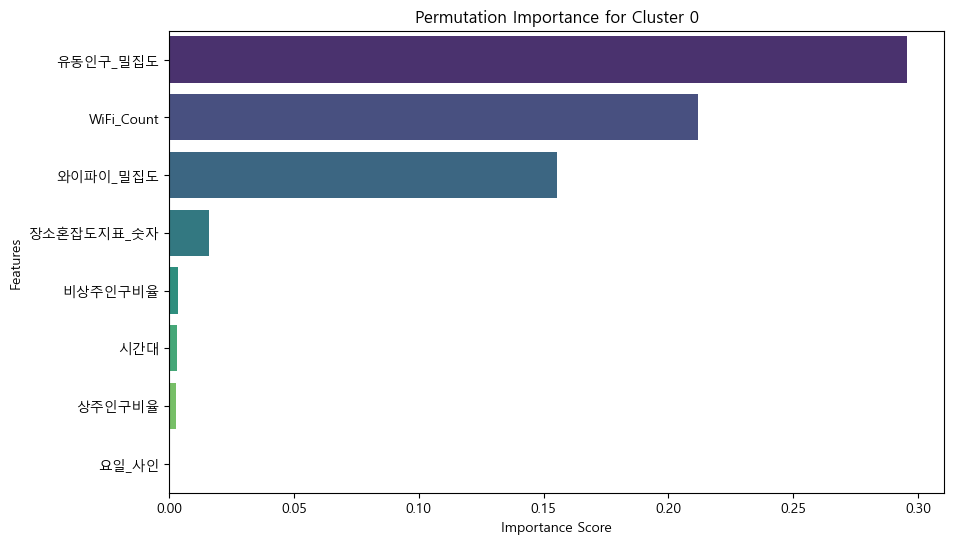

Cluster 3 - 중요 변수 분석
      Feature  Importance
3  WiFi_Count    0.304800
4    유동인구_밀집도    0.257679
5    와이파이_밀집도    0.146166
0  장소혼잡도지표_숫자    0.119409
1      상주인구비율    0.064318
7         시간대    0.044331
2     비상주인구비율    0.041178
6       요일_사인    0.022120


C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\1344571461.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")


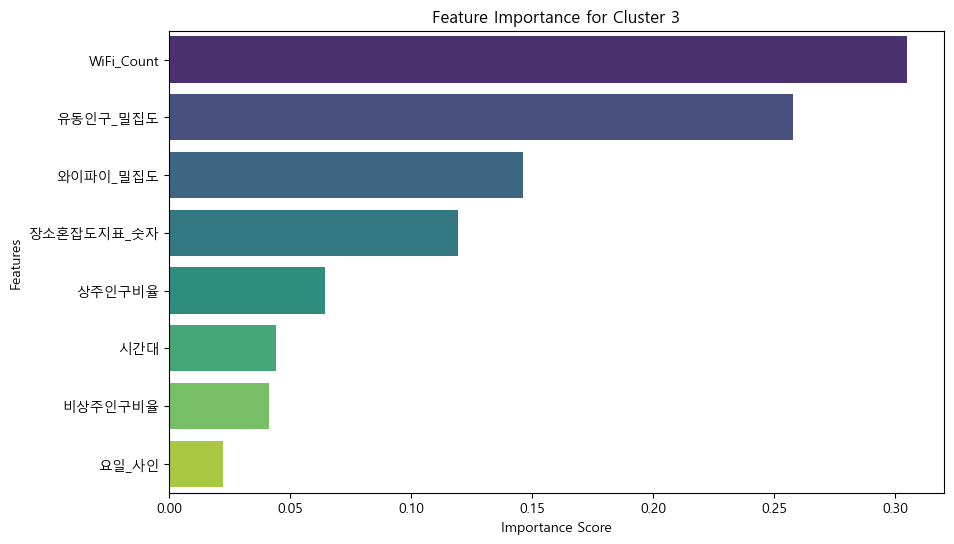


Permutation Importance:
      Feature  Importance
3  WiFi_Count    0.003168
4    유동인구_밀집도    0.002350
5    와이파이_밀집도    0.000127
6       요일_사인    0.000003
2     비상주인구비율    0.000000
1      상주인구비율    0.000000
0  장소혼잡도지표_숫자    0.000000
7         시간대    0.000000


C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\1344571461.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=perm_importance_df, x="Importance", y="Feature", palette="viridis")


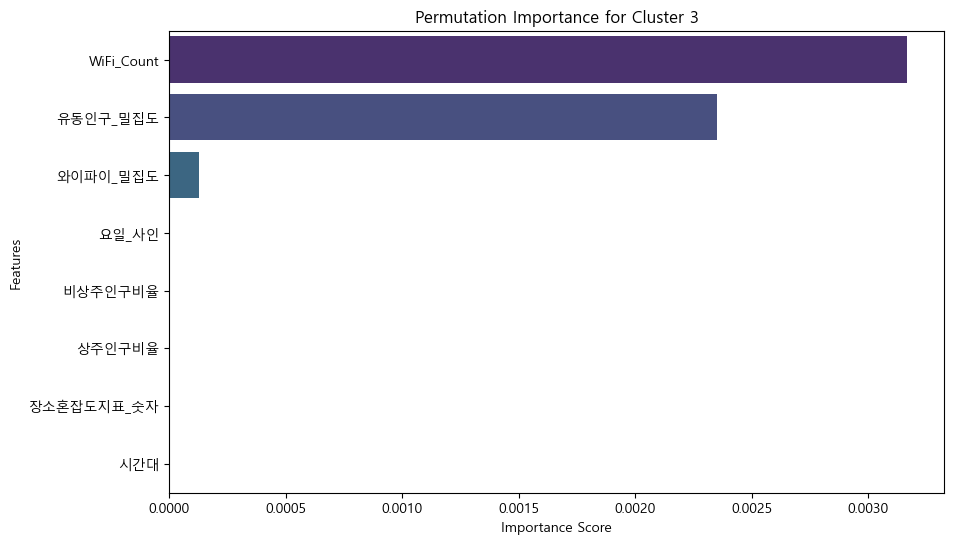

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# 주요 변수와 클러스터링 결과
features = [
    "실시간인구지표최대값",
    "장소혼잡도지표_숫자",
    "상주인구비율",
    "비상주인구비율",
    "WiFi_Count",
    "유동인구_밀집도",
    "와이파이_밀집도",
    "요일_사인",
    "시간대",
]
cluster_column = "CLUSTERING"

# 클러스터별로 데이터 분리
for cluster in foot_traffic_loc_with_area[cluster_column].unique():
    print(f"Cluster {cluster} - 중요 변수 분석")
    
    # 현재 군집 vs 나머지 군집으로 데이터 재구성
    foot_traffic_loc_with_area["Is_Target_Cluster"] = (foot_traffic_loc_with_area[cluster_column] == cluster).astype(int)
    
    # Feature와 Target 정의
    X = foot_traffic_loc_with_area[features]
    y = foot_traffic_loc_with_area["Is_Target_Cluster"]
    
    # Random Forest 모델 훈련
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
    rf_model.fit(X, y)
    
    # 변수 중요도 확인
    feature_importance = pd.DataFrame({
        "Feature": features,
        "Importance": rf_model.feature_importances_,
    }).sort_values(by="Importance", ascending=False)
    
    # 출력
    print(feature_importance)
    
    # 변수 중요도 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance, x="Importance", y="Feature", palette="viridis")
    plt.title(f"Feature Importance for Cluster {cluster}")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()
    
    # Permutation Importance (Optional)
    perm_importance = permutation_importance(rf_model, X, y, n_repeats=10, random_state=42)
    perm_importance_df = pd.DataFrame({
        "Feature": features,
        "Importance": perm_importance["importances_mean"]
    }).sort_values(by="Importance", ascending=False)
    
    # 출력
    print("\nPermutation Importance:")
    print(perm_importance_df)
    
    # 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(data=perm_importance_df, x="Importance", y="Feature", palette="viridis")
    plt.title(f"Permutation Importance for Cluster {cluster}")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()


In [75]:
foot_traffic_loc_with_area[foot_traffic_loc_with_area['CLUSTERING']==3]['AREA_NM'].unique()

array(['여의도'], dtype=object)

# 3. 분석 결론

C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\2277743178.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=foot_traffic_loc_with_area, x=cluster_column, y=feature, palette="Set2")
C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\2277743178.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=foot_traffic_loc_with_area, x=cluster_column, y=feature, palette="Set2")
C:\Users\jungb\AppData\Local\Temp\ipykernel_57288\2277743178.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=foot_traffic_loc_with_area, x=cluster_column

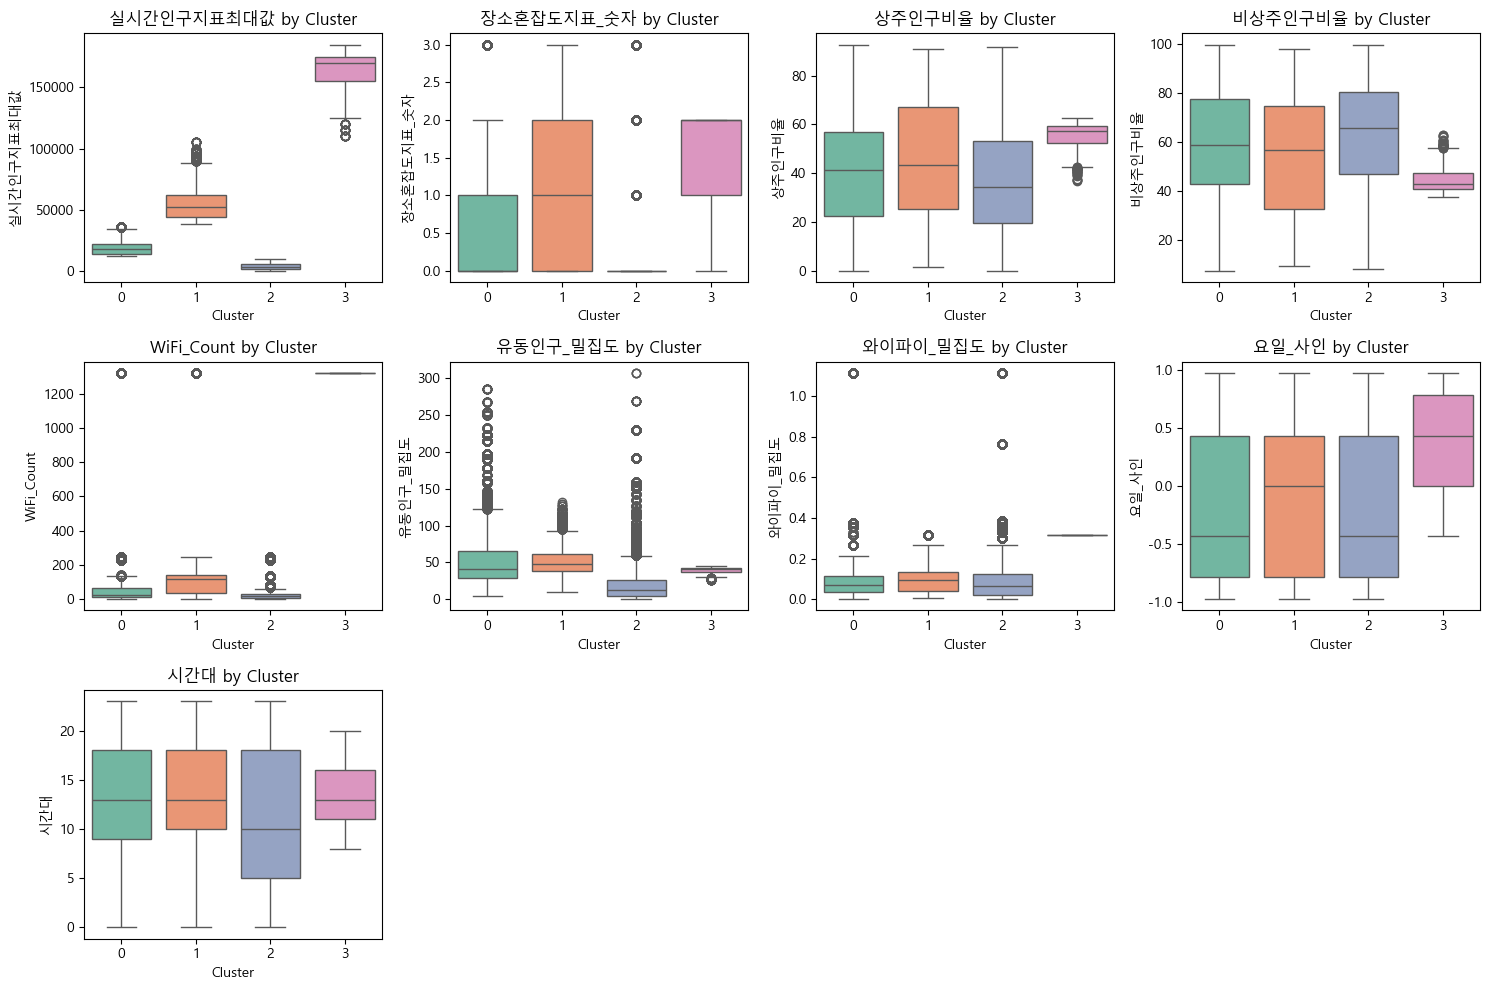

In [ ]:
features = [
    "실시간인구지표최대값",
    "장소혼잡도지표_숫자",
    "상주인구비율",
    "비상주인구비율",
    "WiFi_Count",
    "유동인구_밀집도",
    "와이파이_밀집도",
    "요일_사인",
    "시간대",
]

cluster_column = "CLUSTERING"

# 1. 군집별 주요 변수 요약
cluster_summary = (
    foot_traffic_loc_with_area.groupby(cluster_column)[features]
    .agg(["mean", "median", "std"])
    .reset_index()
)

# 2. 변수별 군집 간 차이 시각화
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(data=foot_traffic_loc_with_area, x=cluster_column, y=feature, palette="Set2")
    plt.title(f"{feature} by Cluster")
    plt.xlabel("Cluster")
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

- 군집 0: 균형적인 지역
> - 실시간 인구 지표: 낮은 수준, 안정적임.
> - 장소 혼잡도: 중간 수준, 큰 편차 없음.
> - 상주 인구 비율: 중간 정도로 안정적.
> - 비상주 인구 비율: 상주 인구와 비슷한 수준, 균형이 잡혀 있음.
> - WiFi 개수: 낮은 편.
> - 유동 인구 밀집도: 중간 수준, 큰 편차 없음.
> - WiFi 밀집도: 낮은 수준으로 안정적.
> - 요일 사인: 주중과 주말이 균형적임.
> - 시간대: 다양한 시간대에 걸쳐 분포.
> - 특징
>> - 유동인구와 상주·비상주 인구 비율이 균형적으로 분포된 지역.
>> - WiFi와 관련된 지표가 안정적이지만 상대적으로 낮음.

- 군집 1: 상주 인구 중심 지역
> - 실시간 인구 지표: 중간 정도.
> - 장소 혼잡도: 중간 정도로 안정적.
> - 상주 인구 비율: 가장 높은 수준.
> - 비상주 인구 비율: 낮음.
> - WiFi 개수: 낮음.
> - 유동 인구 밀집도: 중간 수준.
> - WiFi 밀집도: 낮음.
> - 요일 사인: 주중에 집중.
> - 시간대: 주중 낮 시간대 활동성이 높음.
> - 특징
>> - 상주 인구가 대부분을 차지하는 지역.
>> - 비상주 인구가 적고 WiFi와 관련된 지표는 낮음.

- 군집 2: 비상주 인구 중심 지역
> - 실시간 인구 지표: 낮음.
> - 장소 혼잡도: 낮음.
> - 상주 인구 비율: 중간 수준.
> - 비상주 인구 비율: 가장 높음.
> - WiFi 개수: 높음.
> - 유동 인구 밀집도: 낮음.
> - WiFi 밀집도: 높음.
> - 요일 사인: 주말에 집중.
> - 시간대: 특정 시간대에 집중되지 않고 분산.
> - 특징
>> - 비상주 인구가 주를 이루는 지역.
>> - WiFi 관련 지표가 높아, 외부 방문객의 활동이 많은 지역으로 보임.
- 군집 3: 특수 지역 (여의도 중심)
> - 실시간 인구 지표: 가장 높음.
> - 장소 혼잡도: 높음.
> - 상주 인구 비율: 높음.
> - 비상주 인구 비율: 매우 낮음.
> - WiFi 개수: 매우 높음.
> - 유동 인구 밀집도: 중간 수준.
> - WiFi 밀집도: 가장 높음.
> - 요일 사인: 주중 활동성 높음.
> - 시간대: 출퇴근 시간대와 주중 낮 시간에 집중.
> - 특징
>> - 여의도라는 특수 지역으로, 업무와 행정 중심지의 특징을 보임.
>> - WiFi와 관련된 지표가 매우 높고, 비상주 인구가 거의 없음.

- `군집 0`: 균형적 지역으로, 상주 및 비상주 인구가 고르게 분포. WiFi 관련 지표는 낮음.
- `군집 1`: 상주 인구 중심 지역으로, 주중 낮 시간대 활동성이 높음.
- `군집 2`: 비상주 인구 중심 지역으로, 외부 방문객 활동이 많고 WiFi 관련 지표가 높음.
- `군집 3`: 여의도처럼 특수한 업무 중심 지역으로, 매우 높은 WiFi 밀집도와 실시간 인구 지표를 가짐.

### 결론 :
- `군집 0`: 
> - 균형 잡힌 지역으로, 유동 인구와 상주·비상주 인구가 고르게 분포됨.
> - WiFi 지표가 낮아 공공 WiFi 확충이 필요할 가능성이 있음.
> - 추가 설치 시, 큰 편차 없이 모든 사용자에게 고르게 혜택을 줄 수 있는 지역.

- `군집 1`: 
> - 주거지역 중심으로, 상주 인구가 주를 이루는 지역.
> - 공공 WiFi 사용자는 상주민(주민)일 가능성이 높아, 필요성이 제한적일 수 있음.
> - 예산 삭감 상황에서는 우선순위에서 제외 가능.

- `군집 2`:
> - 관광지나 외부 방문객 중심 지역으로, 비상주 인구가 주를 이룸.
> - 이미 WiFi 개수와 밀집도가 높은 편이지만, 방문객 편의를 위해 추가 확충이 효과적일 가능성.
> - 관광지와 같은 장소는 공공 WiFi 사용량이 많으므로, 추가 설치는 방문객 만족도 향상에 기여 가능.

- `군집 3`:
> - 업무 중심지로, 사내 WiFi를 많이 사용하는 특수한 환경.
> - 이미 높은 WiFi 밀집도를 보이며, 공공 WiFi의 추가 설치 필요성이 낮음.
> - 예산 삭감 상황에서는 추가 설치보다 기존 네트워크 유지보수 및 안정성 확보에 집중.

- 와이파이 설치 우선순위 :
1. `군집 2(비상주 인구 중심 지역)`:
> - 외부 방문객이 많아 공공 WiFi의 필요성이 높음.
> - 추가 설치가 방문객 편의 증대에 직접적으로 기여.

2. `군집 0(균형 지역)`:
> - 유동 인구와 인구 비율이 고르게 분포되어 있음.
> - 공공 WiFi 추가 설치로 지역적 균형 효과를 기대할 수 있음.

3. `군집 1(상주 인구 중심 지역)`:
> - 상주 인구가 주로 사용하는 지역으로, 공공 WiFi 사용량이 상대적으로 적을 가능성.

4. `군집 3(여의도)`:
> - 업무 중심 지역으로, 사내 WiFi 의존도가 높아 공공 WiFi 설치 우선순위가 낮음.